In [1]:
import dask.distributed as dsk
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

clnt = dsk.Client()
clnt

Client Scheduler: tcp://127.0.0.1:45451 Dashboard: /proxy/37989/status,Cluster Workers: 4 Cores: 16 Memory: 200.00 GiB


In [2]:
uas = xr.open_dataset('../data/uas-erai-monthly-1979_2015.nc')['uas'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01')).mean('time')
vas = xr.open_dataset('../data/vas-erai-monthly-1979_2015.nc')['vas'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01')).mean('time')

In [60]:
uas = uas.interp(lon = np.arange(-180, 179.2, .2), lat = np.arange(-90, -50.2, .2))
vas = vas.interp(lon = np.arange(-180, 179.2, .2), lat = np.arange(-90, -50.2, .2))

In [3]:
ws = np.sqrt(uas**2 + vas**2)
# mask peninsula to avoid anomalies there:
peninsula_mask = ws.where(ws['lat']<-68).where(ws['lon']>-70).where(ws['lon']<-68)*0
peninsula_mask = peninsula_mask.fillna(1)
peninsula_mask = peninsula_mask.where(peninsula_mask==1)
latitude = ws['lat']
longitude = ws['lon']

def find_min_lat(var):
    # mask outside of 60 and 80S:
    speed_mask = var.where(var['lat']<-60).where(var['lat']>-80)

    # first pass at latitude indices where speed is a minimum:
    min_lat_indices = (peninsula_mask*speed_mask).argmin(dim = 'lat')

    # remove large latitude jumps in min_lat_indices:
    filtered_min_lat_indices = min_lat_indices.copy()
    for i in range(len(longitude)-1):
        if np.abs(min_lat_indices[i+1] - filtered_min_lat_indices[i]) > 10:
            filtered_min_lat_indices[i+1] = np.maximum(min_lat_indices[i+1],filtered_min_lat_indices[i])

    # and apply a smoothing:
    smoothed_min_lat_indices = np.ceil((filtered_min_lat_indices.roll(lon=3,roll_coords=False) + \
                                        filtered_min_lat_indices.roll(lon=2,roll_coords=False) + \
                                        filtered_min_lat_indices.roll(lon=1,roll_coords=False) + \
                                        filtered_min_lat_indices.roll(lon=-1,roll_coords=False) + \
                                        filtered_min_lat_indices.roll(lon=-2,roll_coords=False) + \
                                        filtered_min_lat_indices.roll(lon=-3,roll_coords=False) + filtered_min_lat_indices)/7)

    # pick out latitude values:
    smoothed_min_lat = latitude.isel(lat=smoothed_min_lat_indices.astype(int))
    lat_xarray = xr.DataArray(smoothed_min_lat, dims = {'lon'}, coords = {'lon':longitude})
    #lat_xarray = xr.where((lat_xarray['lon'] < -64) & (lat_xarray['lon'] > -70), np.nan, lat_xarray)
    
    return lat_xarray

In [4]:
div_line = find_min_lat(ws)

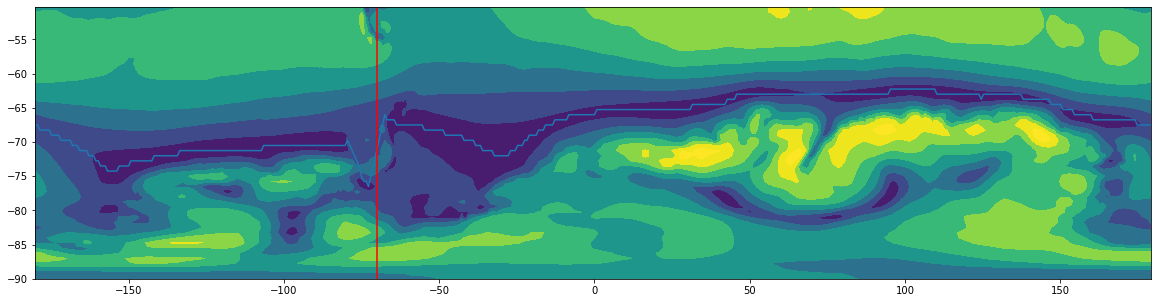

In [5]:
plt.figure(figsize = (20,5))
plt.contourf(uas['lon'], uas['lat'], np.sqrt(uas**2+vas**2), vmin = 0, vmax = 10)
plt.plot(div_line['lon'], div_line)
plt.axvline(x = -70, color = 'r')

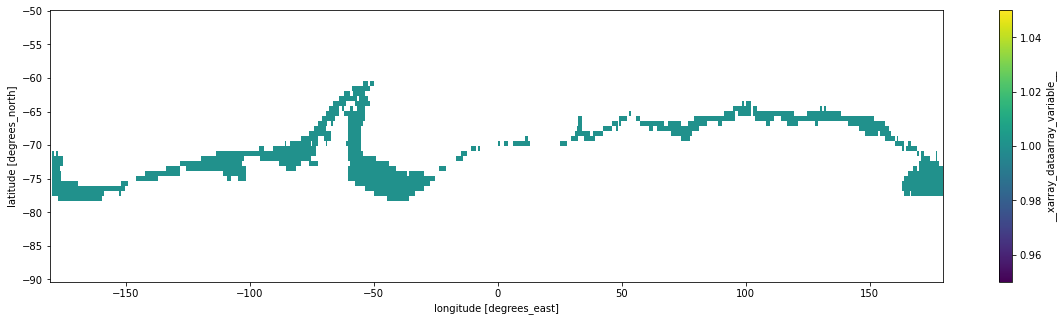

In [6]:
shelf_mask = xr.open_dataset('../data/shelf_mask_1500misobath.nc')['__xarray_dataarray_variable__']
shelf_mask = shelf_mask.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
shelf_mask['_lon_adj'] = xr.where(shelf_mask['lon'] < -180, shelf_mask['lon'] + 360, shelf_mask['lon'])
shelf_mask = shelf_mask.swap_dims({'lon': '_lon_adj'})
shelf_mask = shelf_mask.sel(**{'_lon_adj': sorted(shelf_mask._lon_adj)}).drop('lon')
shelf_mask = shelf_mask.rename({'_lon_adj': 'lon'})
shelf_mask_int = shelf_mask.interp(lon = uas['lon'], lat = uas['lat'])
shelf_mask_int.plot(figsize=(20,5))

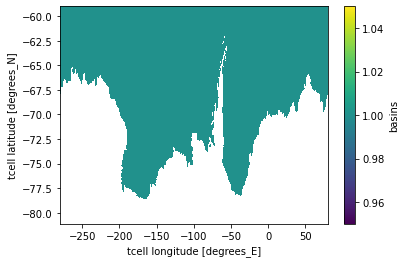

In [7]:
coast_mask = xr.open_dataset('~/g_e14/misc/Antarctic_shelf_basins.nc')['basins']
coast_mask = xr.where(~np.isnan(coast_mask), 1, np.nan)
coast_mask.plot()

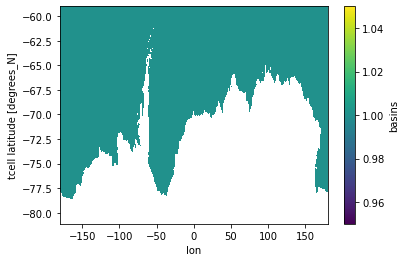

In [8]:
coast_mask = coast_mask.rename(({'xt_ocean':'lon', 'yt_ocean':'lat'}))
coast_mask['_lon_adj'] = xr.where(coast_mask['lon'] < -180, coast_mask['lon'] + 360, coast_mask['lon'])
coast_mask = coast_mask.swap_dims({'lon': '_lon_adj'})
coast_mask = coast_mask.sel(**{'_lon_adj': sorted(coast_mask._lon_adj)}).drop('lon')
coast_mask = coast_mask.rename({'_lon_adj': 'lon'})
coast_mask.plot()

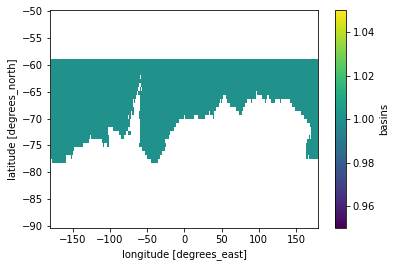

In [9]:
coast_mask = coast_mask.interp(lon = uas['lon'], lat = uas['lat'])
coast_mask.plot()

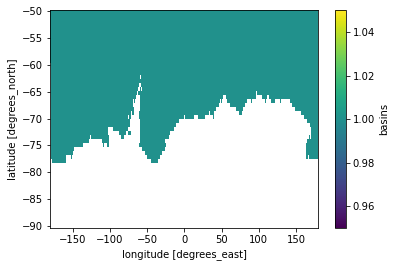

In [10]:
coast_mask = coast_mask.where(coast_mask['lat']<=-59.9, 1)
coast_mask.plot()

In [11]:
mask = np.zeros(np.shape(coast_mask))*np.nan
mask = xr.DataArray(mask, dims = coast_mask.dims, coords = coast_mask.coords)

In [12]:
mask_south_divline = xr.where(mask['lat']<div_line, 1, np.nan)

In [13]:
mask_south_divline_nocoast = xr.where(np.isnan(coast_mask), np.nan, mask_south_divline)

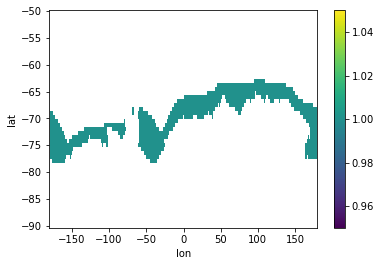

In [14]:
mask_south_divline_nocoast.plot()

Ahora agregar la puta peninsula

In [15]:
mask_with_wap = np.nansum(np.dstack((mask_south_divline_nocoast.values, shelf_mask_int.values)), 2)

In [16]:
mask_with_wap = xr.DataArray(mask_with_wap, dims = coast_mask.dims, coords = coast_mask.coords)

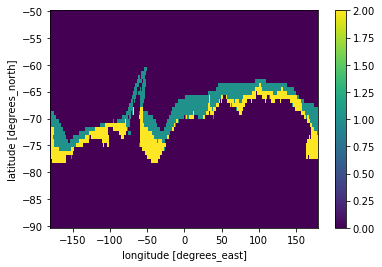

In [17]:
mask_with_wap.plot()

In [18]:
mask_with_wap = xr.where(mask_with_wap!=0, 1, np.nan)

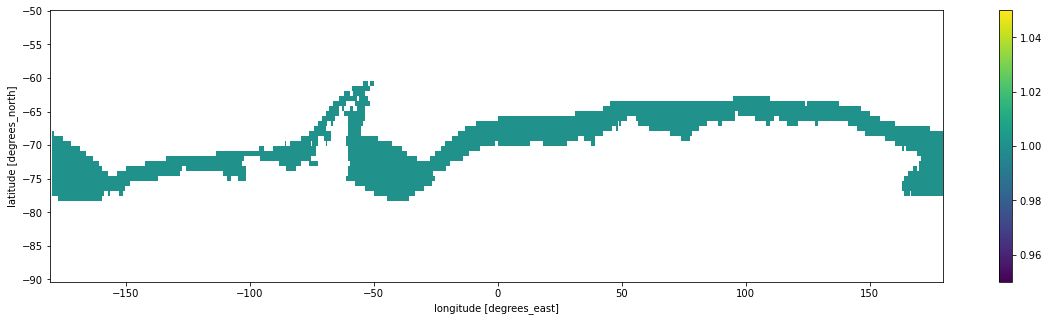

In [19]:
mask_with_wap.plot(figsize=(20,5))

In [20]:
mask_with_wap.to_netcdf('../data/zero_div_line_with_wap_mask_lowres.nc')